# Vuelo 4 20190116 Pelicano

identificacion w (vel. vertical) y r (yaw rate)

* [NeuralNetwork w_cell](#NeuralNetwork_w_cell)
    * [Simulation_cell](#simulation_cell)
* [r: Yaw rate](#yaw_cell)

![title](img/nn.gif)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit
from scipy import signal

In [2]:
# lee de los ficheros *.csv
data_fast = pd.read_csv('d:/20190116_pelicano_vuelos_paso_auto/vuelo4/datos/Fast_Telemetry_20190116_161921.csv', sep=';')
#data_slow = pd.read_csv('../../vuelo3/datos/Slow_Telemetry_20190116_155728.csv', sep=';')

In [3]:
data_fast.head(2)

,time,C001_X,C002_Y,C003_Z,C004_Roll,C005_Pitch,C006_Yaw,C007_vNorte,C008_vEste,C009_vAbajo,...,C130_CME_SERVO_7,C131_CME_RPM_REF,C132_CME_RPM_MED,C133_CME_RPM_SENS,C134_CME_RPM_RAW,C135_CME_P,C136_CME_I,C137_CME_D,C138_CME_T,C139_CME_T_MOD
0,17.195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1023,6100,0,0,0,1278,0,0,3799,6384
1,17.205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1023,6100,0,0,0,1278,0,0,3799,6384


In [4]:
# data_slow.head(2)

In [5]:
# imprime nombre de las columnas
#print('columnas --- fast')
if False:
    for k in data_fast.columns:
        print(k)

In [6]:
#print('columnas --- slow')
#for k in data_slow.columns:
#    print(k)    

Matriz de transformacion $R_b^i$


$$ [x^{(1)} y^{(1)}z^{(1)}]^T=R_b^i(\phi,\theta,\psi) [uvw]$$

con


$$ R_b^i(\phi,\theta,\psi) = \begin{bmatrix}
cos(\theta)cos(\psi) &  sin(\phi)sin(\theta)cos(\psi)-cos(\phi)sin(\psi) & cos(\phi)sin(\theta)cos(\psi)+sin(\phi)sin(\psi) \\
cos(\theta)sin(\psi) &  sin(\phi)sin(\theta)sin(\psi)+cos(\phi)cos(\psi) & cos(\phi)sin(\theta)sin(\psi)-sin(\phi)cos(\psi) \\
-sin(\theta)         &          sin(\phi)cos(\theta)&                                     cos(\phi)cos(\theta)
\end{bmatrix}$$

In [7]:
# matriz transformacion
# [x_dot y_dot z_dot]^T = R_b_i [u v w]^T
#
def get_R_b_i(phi, theta, psi):
    return [
        [np.cos(theta)*np.cos(psi),  np.sin(phi)*np.sin(theta)*np.cos(psi)-np.cos(phi)*np.sin(psi), np.cos(phi)*np.sin(theta)*np.cos(psi)+np.sin(phi)*np.sin(psi)],
        [np.cos(theta)*np.sin(psi),  np.sin(phi)*np.sin(theta)*np.sin(psi)+np.cos(phi)*np.cos(psi), np.cos(phi)*np.sin(theta)*np.sin(psi)-np.sin(phi)*np.cos(psi)],
        [-np.sin(theta),          np.sin(phi)*np.cos(theta),                                     np.cos(phi)*np.cos(theta)]]

In [8]:
# Inercias
Ixx = 163; #% [kg·m^2]
Ixx = 30; #% [kg·m^2] PRUEBAS

Iyy = 59; #% [kg·m^2]
Iyy = 90; #% [kg·m^2] PRUEBAS

Izz = 58; #% [kg·m^2]
Ixy = 0; #% [kg·m^2]
Iyx = 0; #% [kg·m^2]
Ixz = 59; #% [kg·m^2]

#------------------
Ixx = 23; #% [kg·m^2]
Iyy = 77; #% [kg·m^2]
Izz = 68; #% [kg·m^2]
Ixy = 0; #% [kg·m^2]
Iyx = 0; #% [kg·m^2]
Ixz = 0; #% [kg·m^2]

In [9]:
# determina rango valido de datos: n_ini, n_end
t_raw  = data_fast['time'].values 

n_ini = np.where(t_raw>1e8)
print(n_ini)
n_ini = n_ini[0][0]
print(n_ini)
time_0 = t_raw[n_ini]
print('time_0=', time_0)

print(time_0)

# actualiza t
t = t_raw[n_ini:] - time_0

(array([   700,    701,    702, ..., 111630, 111631, 111632], dtype=int64),)
700
time_0= 1547650680.209
1547650680.209


In [10]:
# tini
nini = n_ini


t_raw  = data_fast['time'][nini:].values - time_0

x_dot_raw =     data_fast['C007_vNorte'][nini:].values
y_dot_raw =     data_fast['C008_vEste'][nini:].values
z_dot_raw =     data_fast['C009_vAbajo'][nini:].values

d_col_raw = data_fast['c074_Collective'][nini:].values/1000.0
d_lon_raw = data_fast['C075_Lon_cyclic'][nini:].values/1000.0 - 1.0
d_lat_raw = data_fast['C076_Lat_cyclic'][nini:].values/1000.0 - 1.0
d_ped_raw = data_fast['C077_Tail'][nini:].values/1000.0 - 1.0

rpm = data_fast['C067_RotorRPM'][nini:].values

# salida estimador ?
p_raw = data_fast['C010_wRoll'][nini:].values
q_raw = data_fast['C011_wPitch'][nini:].values
r_raw = data_fast['C012_wYaw'][nini:].values

roll_raw = data_fast['C004_Roll'][nini:].values
pitch_raw = data_fast['C005_Pitch'][nini:].values
yaw_raw = data_fast['C006_Yaw'][nini:].values


# imu
p_raw = data_fast['C019_Wx_IMU'][nini:].values
q_raw = data_fast['C020_Wy_IMU'][nini:].values
r_raw = data_fast['C021_Wz_IMU'][nini:].values

az_raw = data_fast['C024_Az_IMU'][nini:].values

roll_raw = data_fast['C027_Roll_IMU'][nini:].values
pitch_raw = data_fast['C025_Pitch_IMU'][nini:].values
yaw_raw = data_fast['C026_Yaw_IMU'][nini:].values

# numero elementos
N = rpm.size

# fuerza Ts
Ts = 10E-3
# gravedad
g=9.81

In [11]:
# FILTRADO
Fs = 100
Fpwm = 15
b_f,a_f = signal.butter(3, (Fpwm/2)/(Fs/2))

x_dot_f     = signal.filtfilt(b_f,a_f,x_dot_raw)
y_dot_f     = signal.filtfilt(b_f,a_f,y_dot_raw)
z_dot_f     = signal.filtfilt(b_f,a_f,z_dot_raw)
p_f     = signal.filtfilt(b_f,a_f,p_raw)
q_f     = signal.filtfilt(b_f,a_f,q_raw)
r_f     = signal.filtfilt(b_f,a_f,r_raw)
d_col_f     = signal.filtfilt(b_f,a_f,d_col_raw)
d_lat_f     = signal.filtfilt(b_f,a_f,d_lat_raw)
d_lon_f     = signal.filtfilt(b_f,a_f,d_lon_raw)
d_ped_f     = signal.filtfilt(b_f,a_f,d_ped_raw)

az_f = signal.filtfilt(b_f,a_f,az_raw)

roll_f  = signal.filtfilt(b_f,a_f,roll_raw)
pitch_f  = signal.filtfilt(b_f,a_f,pitch_raw)
yaw_f  = signal.filtfilt(b_f,a_f,yaw_raw)

In [12]:
# generamos los vectores para u,v,w a partir de x_dot, y_dot, z_dot
Nd = yaw_f.size

u_f = np.zeros((Nd))
v_f = np.zeros((Nd))
w_f = np.zeros((Nd))

# inicialmente roll_0 = pitch_0 = 0
roll_0 = 0
pitch_0 = 0

(538, 615)

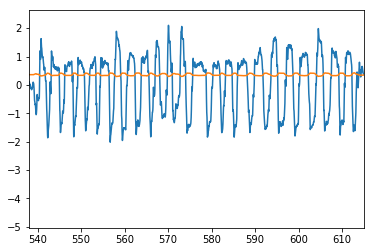

In [13]:
##################################
n_ini = np.where(t_raw>538)[0][0]
n_end = np.where(t_raw>615)[0][0]
##################################


roll_0  = roll_f[n_ini:n_end].mean()
pitch_0 = pitch_f[n_ini:n_end].mean()

# actualiza offset para roll y pitch
roll_f = roll_f - roll_0
pitch_f = pitch_f - pitch_0
plt.plot(t,az_f-az_f.mean())
plt.plot(t,d_col_f)
plt.xlim(538,615)


In [14]:
for k in range(0,Nd):
    R_b_i = get_R_b_i(roll_f[k], pitch_f[k], yaw_f[k])
    # transpose
    R_b_i_T = np.transpose(R_b_i)
    uvw = np.matmul(R_b_i_T, np.array([[x_dot_f[k]],[y_dot_f[k]], [z_dot_f[k]]]))
    u_f[k] = uvw[0]
    v_f[k] = uvw[1]
    w_f[k] = uvw[2]

(400, 1200)

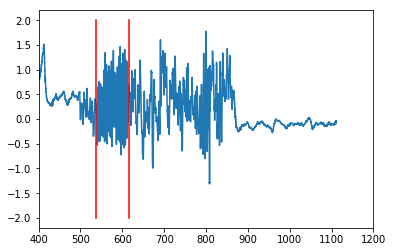

In [15]:
# region de interes

plt.plot(t,w_f)

plt.plot([t_raw[n_ini] ,t_raw[n_ini]],[-2, 2],'r')
plt.plot([t_raw[n_end] ,t_raw[n_end]],[-2, 2],'r')
plt.xlim(400,1200)

(538.0089998245239, 615.0089998245239)

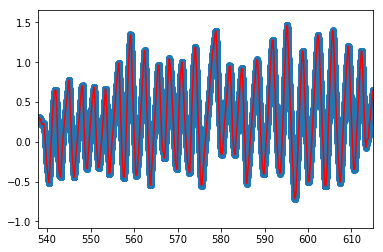

In [16]:
plt.plot(t, z_dot_raw[:],'o')
plt.plot(t, z_dot_f[:],'r')
#plt.plot(td, z_dot_fd[:],'.-c')

plt.xlim(t[n_ini],t[n_end])
#plt.ylim(-.5,.1)

d_col_0 =  0.3593808085649553
d_lat_0 =  -0.31764002278197984
d_lon_0 =  0.38133059024730326


(538.0089998245239, 615.0089998245239)

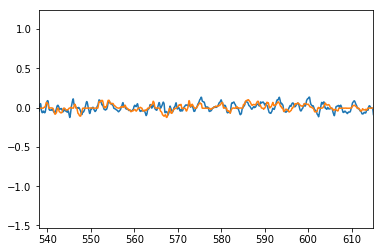

In [17]:
# eliminamos valores medios de los mandos (trimado)
d_col_0 = d_col_f[n_ini:n_end].mean()
d_lat_0 = d_lat_f[n_ini:n_end].mean()
d_lon_0 = d_lon_f[n_ini:n_end].mean()

print('d_col_0 = ',d_col_0)
print('d_lat_0 = ',d_lat_0)
print('d_lon_0 = ',d_lon_0)

# actualizamos los mandos
if True:
    d_col_f = d_col_f- d_col_0
    d_lat_f = d_lat_f- d_lat_0
    d_lon_f = d_lon_f- d_lon_0

# plt
plt.plot(t,d_lon_f)
plt.plot(t,d_lat_f)
plt.xlim(t[n_ini],t[n_end])

# neural network w
<a id='NeuralNetwork_w_cell'></a>

In [18]:
from sklearn.neural_network import MLPRegressor

## Identificacion w
<a id='NeuralNetwork_w_cell'></a>
Rango de tiempo 538-615 [s]

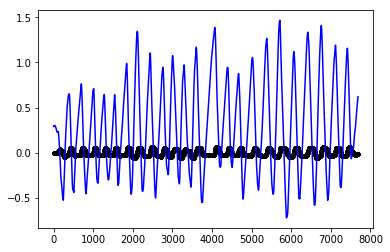

In [19]:
w_ini = np.where(t>538)[0][0]
w_end = np.where(t>615)[0][0]

plt.figure()
plt.plot(d_col_f[w_ini:w_end],'k.-', label='d_col_f')
plt.plot(w_f[w_ini:w_end],'b', label='w_f')


(400, 1200)

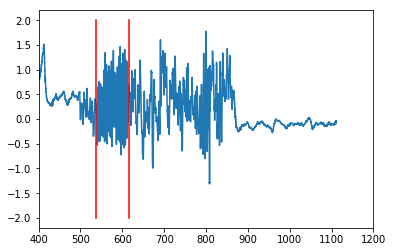

In [20]:
# region de interes

plt.plot(t,w_f)

plt.plot([t_raw[n_ini] ,t_raw[n_ini]],[-2, 2],'r')
plt.plot([t_raw[n_end] ,t_raw[n_end]],[-2, 2],'r')
plt.xlim(400,1200)

In [21]:
X = np.vstack((
    w_f[w_ini-1:w_end-1],
    d_col_f[w_ini:w_end])).T  
y = w_f[w_ini:w_end]
mlp = MLPRegressor(hidden_layer_sizes=(1),solver ='lbfgs', tol=1e-13, verbose=True, learning_rate='constant', activation='identity',max_iter=2000, random_state=101)
mlp.fit(X,y)

print('n_iter_=', mlp.n_iter_ )
print('loss_=', mlp.loss_ )

n_iter_= 31
loss_= 2.8021025550259055e-06


0.002353969111703124

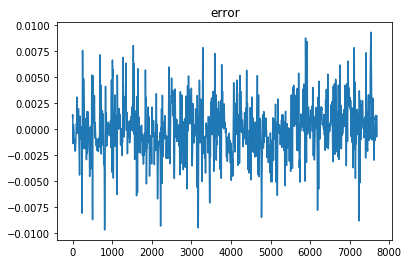

In [22]:
y_pred = mlp.predict(X)
error = y-y_pred

plt.plot(error)
plt.title('error')
#plt.plot(y)
np.std(error)

7688
[0.29036639 0.2917762  0.29326593 ... 0.61248833 0.61651575 0.62069427]
110933


Text(0.5, 1.0, 'w [m/s]')

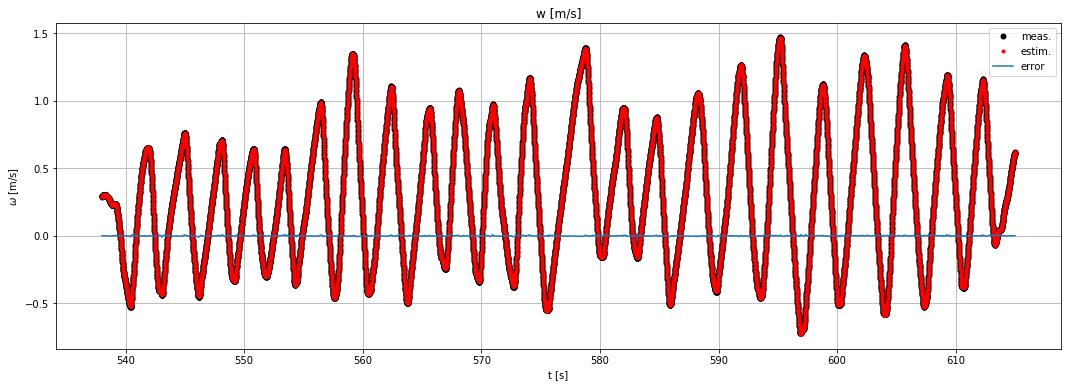

In [23]:
plt.figure(figsize=(18,6))
print(y.size)
print(y)
print(t.size)
plt.plot(t[w_ini:w_end],y,'.k',ms=10, label='meas.')
plt.plot(t[w_ini:w_end],y_pred,'.r',lw=.5, label='estim.')

plt.plot(t[w_ini:w_end],error,label='error')
#plt.xlim(912.25, 912.45)
#plt.ylim(-0., .2)
plt.grid()
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('$\omega$ [m/s]')
plt.title('w [m/s]')

In [24]:
print(mlp.coefs_)
print(mlp.intercepts_)

[array([[-2.0722789 ],
       [ 0.56421695]]), array([[-0.48293997]])]
[array([-0.34648364]), array([-0.16752209])]


In [25]:
mlp.predict([[0,0]])
Z_w = mlp.predict([[1,0]])
Z_col = mlp.predict([[0,1]])

print('w[k+1] = Z_w  w[k]  + Z_col d[k]')
print('Z_w = ', Z_w)
print('Z_col = ', Z_col)

w[k+1] = Z_w  w[k+1]  + Z_col d[k]
Z_w =  [1.00059503]
Z_col =  [-0.27267421]


In [39]:
Ts/(1-1.00059503)

-16.80587533401844

# simulacion
<a id='simulation_cell'></a>

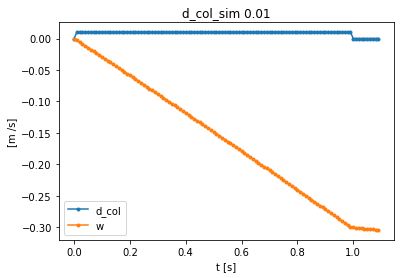

In [26]:
N =110
t_sim = np.arange(0,N)*Ts

w_sim = np.zeros(N)
d_col_sim = np.zeros(N)

for k in range(1,N):
    if k<1:
        d_col_sim[k]=-0
    elif k<100:
        d_col_sim[k]=.01
    elif k<120:
        d_col_sim[k]=-0
    else:
        d_col_sim[k]=0
        
    X = [[w_sim[k-1], d_col_sim[k]]]
    y = mlp.predict(X)
    w_sim[k] = y[0]

plt.figure()
plt.title('d_col_sim 0.01')
plt.plot(t_sim,d_col_sim, '.-', label='d_col')    
plt.plot(t_sim,w_sim, '.-', label='w')    
plt.xlabel('t [s]')
plt.ylabel('[m /s]')
#plt.ylim(-.05,.05)
plt.legend()


## r: yaw rate
<a id='yaw_cell'></a>
Rango de tiempo 643.5...700 [s]

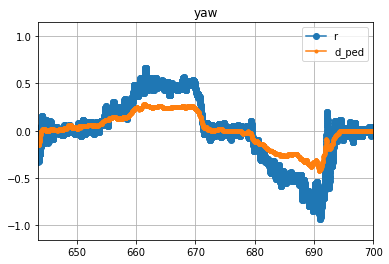

In [27]:
plt.title('yaw')
plt.plot(t,r_f,'o-', label='r ')
plt.plot(t,d_ped_f,'.-', label='d_ped')
plt.xlim(643.5,700)
plt.legend()
plt.grid()
n_yaw_ini = np.where(t>643.5)[0][0]
n_yaw_end = np.where(t>700)[0][0]


Text(0.5, 1.0, 'region interes r')

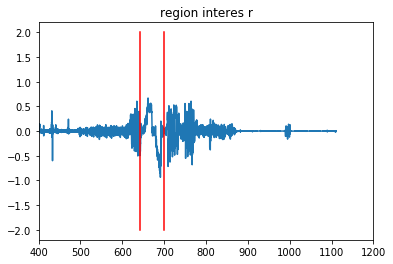

In [28]:
# region de interes
plt.plot(t,r_f)

plt.plot([t_raw[n_yaw_ini] ,t_raw[n_yaw_ini]],[-2, 2],'r')
plt.plot([t_raw[n_yaw_end] ,t_raw[n_yaw_end]],[-2, 2],'r')
plt.xlim(400,1200)
plt.title('region interes r')

In [29]:
X = d_ped_f[n_yaw_ini:n_yaw_end].reshape(-1,1)
y = r_f[n_yaw_ini:n_yaw_end]
mlp = MLPRegressor(hidden_layer_sizes=(1),solver ='lbfgs', tol=1e-13, verbose=True, learning_rate='constant', activation='identity',max_iter=2000, random_state=101)
mlp.fit(X,y)

print('n_iter_=', mlp.n_iter_ )
print('loss_=', mlp.loss_ )

n_iter_= 11
loss_= 0.0023166994218054657


0.06806857837450676

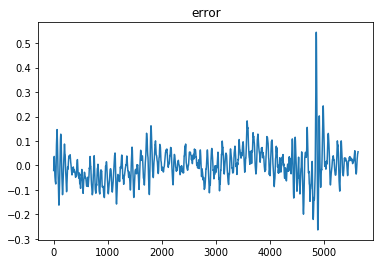

In [30]:
y_pred = mlp.predict(X)
error = y-y_pred

plt.plot(error)
plt.title('error')
#plt.plot(y)
np.std(error)

5640
[-0.32624286 -0.32163698 -0.3166945  ...  0.03518042  0.036856
  0.03945389]
110933


Text(0, 0.5, '$r$ [rad/s]')

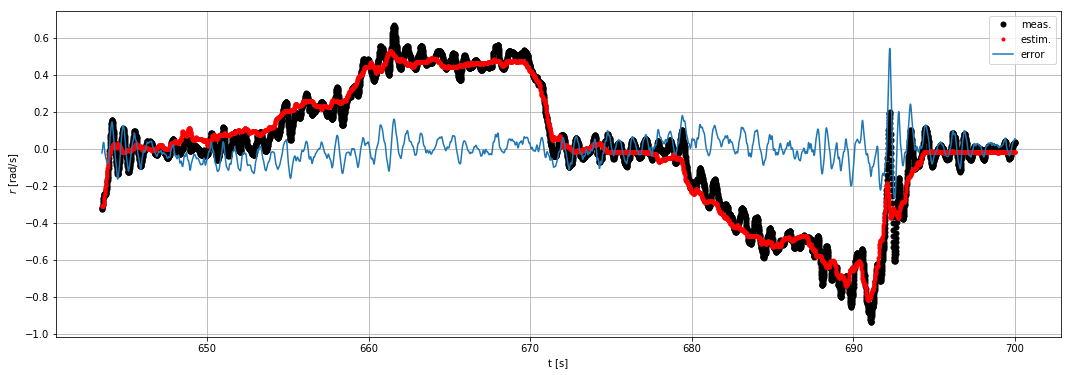

In [31]:
plt.figure(figsize=(18,6))
print(y.size)
print(y)
print(t.size)
plt.plot(t[n_yaw_ini:n_yaw_end],y,'.k',ms=10, label='meas.')
plt.plot(t[n_yaw_ini:n_yaw_end],y_pred,'.r',lw=.5, label='estim.')

plt.plot(t[n_yaw_ini:n_yaw_end],error,label='error')
#plt.xlim(912.25, 912.45)
#plt.ylim(-0., .2)
plt.grid()
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('$r$ [rad/s]')

In [32]:
print(mlp.coefs_)
print(mlp.intercepts_)

[array([[-1.32466079]]), array([[-1.43220275]])]
[array([-0.47425735]), array([-0.68949691])]


In [33]:
mlp.predict([[0]])
K_ped = mlp.predict([[1]])[0]

print('r[k] = K_ped d_ped[k]')
print('K_ped = ', K_ped)

r[k] = K_ped d_ped[k]
K_ped =  1.886918594924818


# symbolic
deducido a partir de "coefs_ , intercepts_"

In [34]:
from sympy import *

In [35]:
w, K_ped, d_ped = symbols('w K_ped d_ped')

In [36]:
K_ped = (mlp.coefs_[0][0][0]*d_ped + mlp.intercepts_[0])*mlp.coefs_[1][0][0]+mlp.intercepts_[1]

In [37]:
print('K_ped = ', K_ped)

K_ped =  1.89718282236871*d_ped - 0.0102642274438953
